In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# load the data
X_train_og = np.load("/kaggle/input/saved-natural/X_train.npy")
X_test_og = np.load("/kaggle/input/saved-natural/X_test.npy")
y_train_og = np.load("/kaggle/input/saved-natural/y_train.npy")
y_test_og = np.load("/kaggle/input/saved-natural/y_test.npy")

# Normalize input images if needed
X_train = X_train_og / 255.0
X_test = X_test_og / 255.0

# Normalize output images if needed
y_train = y_train_og / 255.0
y_test = y_test_og / 255.0

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
del X_train_og, X_test_og, y_train_og, y_test_og

(5519, 256, 256) (1380, 256, 256) (5519, 256, 256) (1380, 256, 256)


In [5]:
# Check for data range and type
print(f"X_train min: {np.min(X_train)}, max: {np.max(X_train)}")
print(f"X_test min: {np.min(X_test)}, max: {np.max(X_test)}")
print(f"y_train min: {np.min(y_train)}, max: {np.max(y_train)}")
print(f"y_test min: {np.min(y_test)}, max: {np.max(y_test)}")

X_train min: 0.0, max: 1.0
X_test min: 0.0, max: 1.0
y_train min: 0.0, max: 1.0
y_test min: 0.0, max: 1.0


In [6]:
print(np.any(np.isnan(X_train)), np.any(np.isinf(X_train)))
print(np.any(np.isnan(y_train)), np.any(np.isinf(y_train)))

False False
False False


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model():
    inputs = layers.Input(shape=(256, 256, 1))
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)          # Output size: (128, 128)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)          # Output size: (64, 64)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [9]:
def save_metrics_to_file(metrics, filename):
    with open(filename, 'w') as f:
        for epoch in range(len(metrics['train_mse'])):
            f.write(f"{epoch}, {metrics['train_mse'][epoch]}, {metrics['val_mse'][epoch]}, "
                    f"{metrics['train_mae'][epoch]}, {metrics['val_mae'][epoch]}\n")

# Function to load metrics from a file
def load_metrics_from_file(filename):
    metrics = {'train_mse': [], 'val_mse': [], 'train_mae': [], 'val_mae': []}
    with open(filename, 'r') as f:
        for line in f:
            epoch, train_mse, val_mse, train_mae, val_mae = map(float, line.strip().split(', '))
            metrics['train_mse'].append(train_mse)
            metrics['val_mse'].append(val_mse)
            metrics['train_mae'].append(train_mae)
            metrics['val_mae'].append(val_mae)
    return metrics

# Function to plot the stored metrics
def plot_stored_metrics(metrics, label):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train_mse'], label=f'{label} Train MSE')
    plt.plot(metrics['val_mse'], label=f'{label} Val MSE')
    plt.plot(metrics['train_mae'], label=f'{label} Train MAE')
    plt.plot(metrics['val_mae'], label=f'{label} Val MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.title(f'{label} Training and Validation Metrics')
    plt.show()

In [11]:
model_fixed_lr = build_model()
model_fixed_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss='mse',
                       metrics=['mse', 'mae'])

metrics_fixed_lr = {'train_mse': [], 'val_mse': [], 'train_mae': [], 'val_mae': []}

for epoch in range(10):  # Assuming you want to run for 10 epochs
    history = model_fixed_lr.fit(
        X_train, y_train,
        epochs=1,  # Train for one epoch at a time
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0  # Suppress output for clarity
    )

    metrics_fixed_lr['train_mse'].append(history.history['mse'][0])
    metrics_fixed_lr['val_mse'].append(history.history['val_mse'][0])
    metrics_fixed_lr['train_mae'].append(history.history['mae'][0])
    metrics_fixed_lr['val_mae'].append(history.history['val_mae'][0])

# Save metrics to file
save_metrics_to_file(metrics, 'metrics_fixed_lr.txt')

# Save model
model_fixed_lr.save("sobel_filter_model_fixed_lr.h5")


Epoch 1/10


I0000 00:00:1725172216.393424      82 service.cc:145] XLA service 0x7a621808dd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725172216.393484      82 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725172253.052933      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 ━━━━━━━━━━━━━━━━━━━━ 138s 564ms/step - loss: 0.0761 - mae: 0.2202 - mse: 0.0761 - val_loss: 0.0196 - val_mae: 0.0894 - val_mse: 0.0196
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - loss: 0.0173 - mae: 0.0824 - mse: 0.0173 - val_loss: 0.0144 - val_mae: 0.0705 - val_mse: 0.0144
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - loss: 0.0139 - mae: 0.0697 - mse: 0.0139 - val_loss: 0.0128 - val_mae: 0.0649 - val_mse: 0.0128
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - loss: 0.0118 - mae: 0.0603 - mse: 0.0118 - val_loss: 0.0108 - val_mae: 0.0551 - val_mse: 0.0108
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - loss: 0.0106 - mae: 0.0556 - mse: 0.0106 - val_loss: 0.0096 - val_mae: 0.0501 - val_mse: 0.0096
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - loss: 0.0093 - mae: 0.0497 - mse: 0.0093 - val_loss: 0.0087 - val_mae: 0.0468 - val_mse: 0.0087
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - loss: 0.0084 - mae: 0.0460 - mse: 0

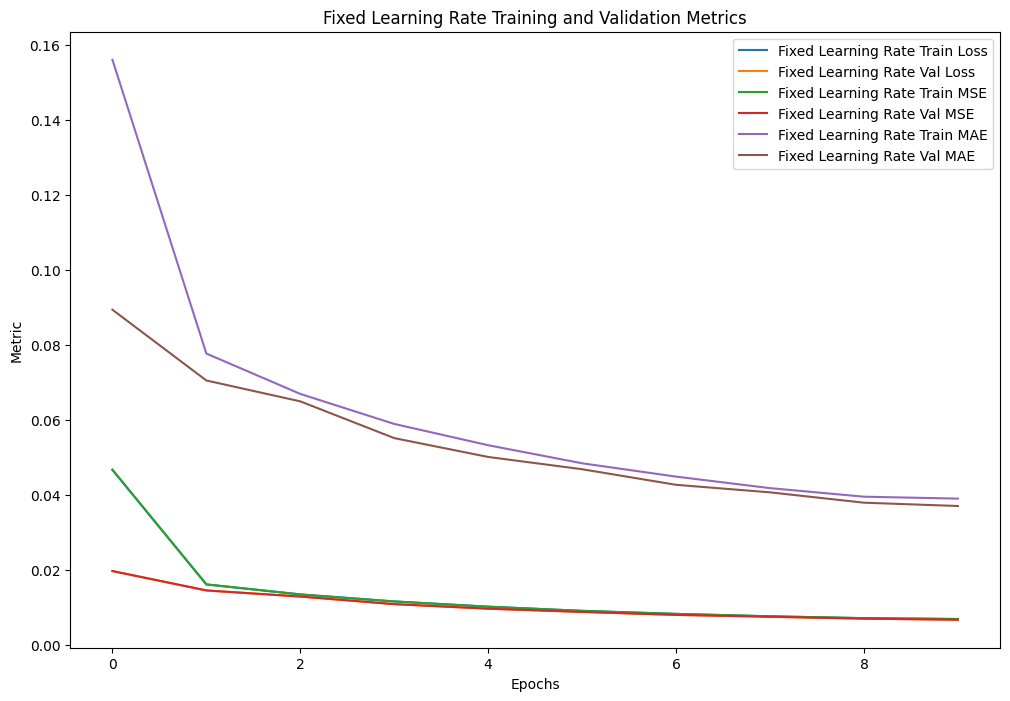

Error evaluating model with fixed learning rate: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}


In [12]:
metrics_fixed_lr = load_metrics_from_file('metrics_fixed_lr.txt')
plot_stored_metrics(metrics_fixed_lr, 'Fixed Learning Rate')

# Evaluate and calculate metrics for the fixed learning rate model
model_fixed_lr = models.load_model("sobel_filter_model_fixed_lr.h5")
_, mse, mae = model_fixed_lr.evaluate(X_test, y_test)
print(f"Test MSE (Fixed LR): {mse}")
print(f"Test MAE (Fixed LR): {mae}")

y_pred_fixed_lr = model_fixed_lr.predict(X_test)
y_pred_fixed_lr = np.squeeze(y_pred, axis=-1)
y_test_fixed_lr = np.squeeze(y_test, axis=-1)

# Ensure y_test and y_pred are in the range [0, 1]
y_test_fixed_lr = np.clip(y_test_fixed_lr, 0.0, 1.0)
y_pred_fixed_lr = np.clip(y_pred_fixed_lr, 0.0, 1.0)

def custom_accuracy(y_true, y_pred, threshold):
    return np.mean(np.abs(y_true - y_pred) <= threshold)

custom_acc = custom_accuracy(y_test_fixed_lr, y_pred_fixed_lr, threshold=0.1)
print(f"Custom Accuracy (Fixed LR): {custom_acc * 100:.2f}%")
print(f"MSE (Fixed LR): {mean_squared_error(y_test_fixed_lr, y_pred_fixed_lr)}")
print(f"MAE (Fixed LR): {mean_absolute_error(y_test_fixed_lr, y_pred_fixed_lr)}")
print(f"SSIM (Fixed LR): {np.mean(ssim(y_test_fixed_lr, y_pred_fixed_lr, data_range=1.0))}")


In [10]:
model_lr_scheduler = build_model()
model_lr_scheduler.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='mse',
                           metrics=['mse', 'mae'])

metrics_lr = {'train_mse': [], 'val_mse': [], 'train_mae': [], 'val_mae': []}

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

for epoch in range(10):
    history = model_lr_scheduler.fit(
        X_train, y_train,
        epochs=1,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0,
        callbacks=[lr_scheduler]
    )

    metrics_lr['train_mse'].append(history.history['mse'][0])
    metrics_lr['val_mse'].append(history.history['val_mse'][0])
    metrics_lr['train_mae'].append(history.history['mae'][0])
    metrics_lr['val_mae'].append(history.history['val_mae'][0])

# Save metrics to file
save_metrics_to_file(metrics_lr, 'metrics_lr_scheduler.txt')

# Save model
model_lr_scheduler.save("sobel_filter_model_lr_scheduler.h5")


Epoch 1/10


I0000 00:00:1725175456.957915      80 service.cc:145] XLA service 0x7c9b28088f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725175456.957974      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725175494.204676      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 ━━━━━━━━━━━━━━━━━━━━ 138s 563ms/step - loss: 0.0517 - mae: 0.1640 - mse: 0.0517 - val_loss: 0.0126 - val_mae: 0.0646 - val_mse: 0.0126 - learning_rate: 0.0010
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 74s 430ms/step - loss: 0.0118 - mae: 0.0628 - mse: 0.0118 - val_loss: 0.0085 - val_mae: 0.0462 - val_mse: 0.0085 - learning_rate: 0.0010
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 74s 430ms/step - loss: 0.0078 - mae: 0.0438 - mse: 0.0078 - val_loss: 0.0060 - val_mae: 0.0349 - val_mse: 0.0060 - learning_rate: 0.0010
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 74s 430ms/step - loss: 0.0056 - mae: 0.0347 - mse: 0.0056 - val_loss: 0.0047 - val_mae: 0.0303 - val_mse: 0.0047 - learning_rate: 0.0010
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 74s 430ms/step - loss: 0.0045 - mae: 0.0304 - mse: 0.0045 - val_loss: 0.0037 - val_mae: 0.0256 - val_mse: 0.0037 - learning_rate: 0.0010
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 74s 430ms/step - loss: 0.0038 - mae: 0.0272 - mse: 0.0038 - val_loss: 0.0032 - val_ma

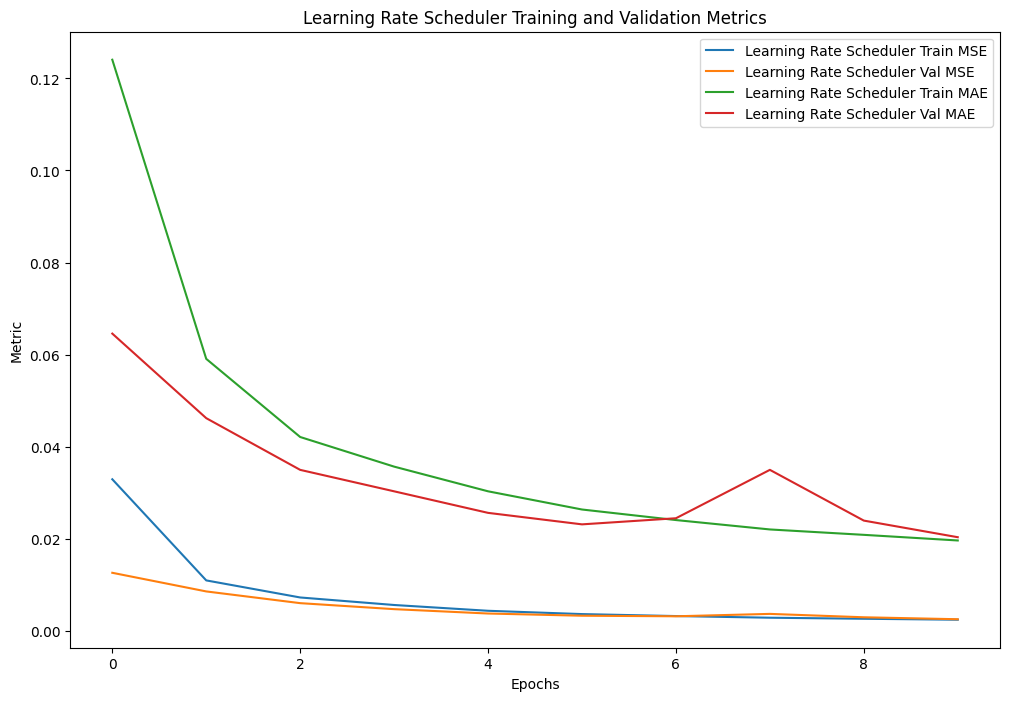

Error evaluating model with learning rate scheduler: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}


In [11]:
metrics_lr = load_metrics_from_file('metrics_lr_scheduler.txt')
plot_stored_metrics(metrics_lr, 'Learning Rate Scheduler')

# Evaluate and calculate metrics for the learning rate scheduler model
model_lr_scheduler = models.load_model("sobel_filter_model_lr_scheduler.h5")
_, mse, mae = model_lr_scheduler.evaluate(X_test, y_test)
print(f"Test MSE (LR Scheduler): {mse}")
print(f"Test MAE (LR Scheduler): {mae}")

y_pred_lr = model_lr_scheduler.predict(X_test)
y_pred_lr = np.squeeze(y_pred, axis=-1)
y_test_lr = np.squeeze(y_test, axis=-1)

# Ensure y_test and y_pred are in the range [0, 1]
y_test_lr = np.clip(y_test_lr, 0.0, 1.0)
y_pred_lr = np.clip(y_pred_lr, 0.0, 1.0)

def custom_accuracy(y_true, y_pred, threshold):
    return np.mean(np.abs(y_true - y_pred) <= threshold)

custom_acc = custom_accuracy(y_test_lr, y_pred_lr, threshold=0.1)
print(f"Custom Accuracy (LR Scheduler): {custom_acc * 100:.2f}%")
print(f"MSE (LR Scheduler): {mean_squared_error(y_test_lr, y_pred_lr)}")
print(f"MAE (LR Scheduler): {mean_absolute_error(y_test_lr, y_pred_lr)}")
print(f"SSIM (LR Scheduler): {np.mean(ssim(y_test_lr, y_pred_lr, data_range=1.0))}")
